In [3]:

%pylab inline
import pandas as pd
from numba import jit
import h5py
import os
#import becquerel
from lmfit.models import LinearModel
from lmfit.models import ExponentialModel
from lmfit.models import GaussianModel
from lmfit.models import QuadraticModel
#import becquerel as bq
from pathlib import Path
#from becquerel.tools import nndc
import IPython.display as iDisplay
#from becquerel.tools.isotope import Isotope
#from becquerel.tools.isotope_qty import IsotopeQuantity, NeutronIrradiation
import datetime
import operator



Populating the interactive namespace from numpy and matplotlib


In [6]:
filename = './DATA_co60_2.h5'  #wherever your file is 
data = h5py.File(filename, 'r')

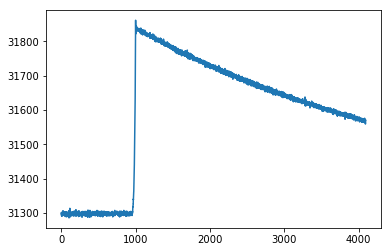

4096

In [7]:
plt.figure()
plt.plot(data['RawData'][2,:])
plt.show()
mysignal = data['RawData'][2,:]
n_data = len(mysignal)
n_data

In [10]:


@jit(parallel = True)
def restore_baseline(signal):
    x = np.argmax(signal)
    baseline = np.mean(signal[0:(x-1)])
    baseline_restore = signal - (baseline*np.ones(len(signal)))
    return baseline_restore



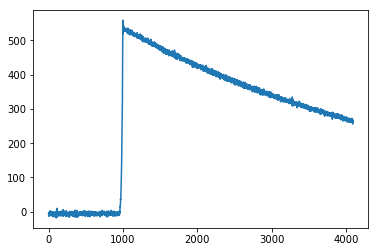

In [11]:
mysignal_restore = restore_baseline(mysignal)
plt.figure()
plt.plot(mysignal_restore)
plt.show()

In [12]:
def exp_fit(signal, plot_comps=None):
    '''
    out = exp_fit takes a range of data that and fits an exponential to the tail
    of the amplitude pulse returning the parameters of the peak
    with out.params

    To access the data do out['exp_amplitude'].value or out['exp_amplitude'].stderr

    signal: input pulse from digitizer
    '''
    x_lbound = np.argmax(signal)
    x_ubound = signal.shape[0]
    
    x_exp = range(x_lbound, x_ubound)
    exp_data = signal[x_exp]
    y = np.asarray(exp_data)
    x = np.asarray(x_exp)

    exp_mod = ExponentialModel(prefix='exp_')
    pars = exp_mod.guess(y, x=x)

    mod = exp_mod

    init = mod.eval(pars, x=x)

    out = mod.fit(y, pars, x=x)
    #print(out.fit_report())

    if plot_comps == True:
        plt.figure()
        plt.plot(signal, 'b')
        plt.plot(x, out.best_fit, 'r--')
        amp = out.params['exp_amplitude'].value
        decay = out.params['exp_decay'].value
        
        plt.annotate('$%0.2f*e^{-x/%0.4f \mu s} ---add units$' % (amp , decay), xy=(1700, 600), xytext=(2000, 650),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

        plt.show()
        
    return out.params

In [13]:
@jit(parallel=True)
def trap_filter_parallel(signal, k, m):
    
    ''' 
    k               Peaking time (in samples) 
    m               Gap time (in samples) 

    Start at 2*k+m
    '''
    
    # ------- Apply exponential fit for the M multiplication --------------#
    #out = exp_fit(signal, plot_comps = False)
    #tau = out['exp_decay'].value #in nanoseconds
    #tau_std = out['exp_decay'].stderr
    #T_sp = 10 #nano seconds
    
#     M = 1/(np.exp(T_sp/tau) - 1)
#     if tau/T_sp > 5:
#         M = tau/T_sp - 0.5
    M= 4400 
    ##---------Start of filter---------------------------#
    
    acc1 = np.zeros(len(signal), dtype = np.float32) # accumulator
    acc2 = np.zeros(len(signal), dtype = np.float32) # accumulator
    sum_3 = np.zeros(len(signal), dtype = np.float32) # accumulator
    sum_4 = np.zeros(len(signal), dtype = np.float32) # accumulator

    for i in range(2*k+m, len(signal)):
        sum_3[i] = signal[i] - signal[i - k] - signal[i - k - m] + signal[i - 2*k-m]
        acc1[i] = sum_3[i] + acc1[i-1] 
        sum_4[i] = acc1[i] + M * sum_3[i]
        acc2[i] =  acc2[i-1] + sum_4[i] 
    return acc2

In [14]:
def trap_filter_plot(signal, k, m, plot_ = None):
    ''' 
    k               Peaking time (in samples) 
    m               Gap time (in samples) 

    Start at 2*k+m
    '''
    # ------- Apply exponential fit for the M multiplication --------------#
    out = exp_fit(signal, plot_comps = False)
    tau = out['exp_decay'].value #in nanoseconds
    tau_std = out['exp_decay'].stderr
    T_sp = 10 #nano seconds
    
#     M = 1/(np.exp(T_sp/tau) - 1)
#     if tau/T_sp > 5:
#         M = tau/T_sp - 0.5
    M= tau  
    ##---------Start of filter---------------------------#
    
    acc1 = np.zeros(len(signal), dtype = np.float32) # accumulator
    acc2 = np.zeros(len(signal), dtype = np.float32) # accumulator
    sum_3 = np.zeros(len(signal), dtype = np.float32) # accumulator
    sum_4 = np.zeros(len(signal), dtype = np.float32) # accumulator

    for i in range(2*k+m, len(signal)):
        sum_3[i] = signal[i] - signal[i - k] - signal[i - k - m] + signal[i - 2*k-m]
        acc1[i] = sum_3[i] + acc1[i-1] 
        sum_4[i] = acc1[i] + M * sum_3[i]
        acc2[i] =  acc2[i-1] + sum_4[i] 
    
    if plot_ == True:
        plt.figure()
        plt.plot(acc2)
        plt.title('Shaped Signal')
        plt.xlabel('Time $[ns]$')
        plt.ylabel('Digital Code')
        plt.show()
    return acc2

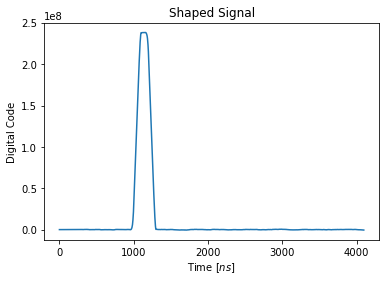

In [15]:
trap_signal = trap_filter_plot(mysignal_restore, 100, 100, plot_ = True)

In [16]:
@jit(parallel = True)
def trap_spectrum(rawdata):
    '''
    trap_spectrum(rawdata) takes the raw data spectrum from the hdf5 and does the following to the whole file:
    * baseline restore
    * applies an expontential fit to the tail of the pulse
    * trapezoidal filter
    * bins the data 
    '''
    nrg_peaks = np.zeros(len(rawdata), dtype = np.float32)
    for i, pulses in enumerate(rawdata):
        signal_restore = restore_baseline(pulses)
        trap_signal = trap_filter_parallel(signal_restore, 100, 10)
        nrg_peaks[i] = max(trap_signal)
    return nrg_peaks

In [17]:
%time nrg = trap_spectrum(data['RawData'])


CPU times: user 25.2 s, sys: 5.63 s, total: 30.8 s
Wall time: 26.4 s


In [19]:
def bin_data(filtered_signal):   
    '''
    bin_data(filtered_signal) bins the data from a trapezoidal filter
    '''
    counts, bin_edges = np.histogram(filtered_signal, bins=2048, range=[1.0e8, 3.5e8])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    return bin_centers, counts

In [20]:
bc, cnts = bin_data(nrg)

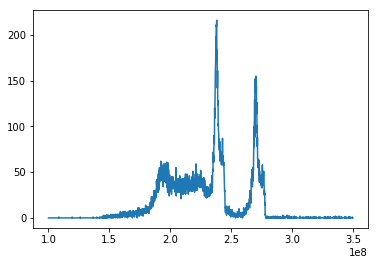

In [21]:
plt.figure()
plt.plot(bc, cnts)

In [23]:
print(len(bc))

2048
